In [139]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [140]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
from sklearn.model_selection import cross_val_score

***EDA***

In [142]:
df = pd.read_csv("data.csv")

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Посмотрим, какое количество пропусков мы имеем в нашем датасете

In [144]:
df.isna().sum().sum()

0

Посмотрим, какой процент компаний обанкротился

In [145]:
df["Bankrupt?"].sum()

220

In [146]:
print((df["Bankrupt?"].sum()/df["Bankrupt?"].count())*100)

3.2262795131250916


Построим матрицу корреляций переменных для того, чтобы понять, есть ли в переменных мультиколлинеарность. Мультиколлинеарность может привести к переобучению модели.

In [147]:
corrtable = df.corr()

In [148]:
corrtable.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
Bankrupt?,1.000000,-0.260807,-0.282941,-0.273051,-0.100043,-0.099445,-0.000230,-0.008517,-0.008857,-0.016593,...,-0.315457,0.035104,-0.005547,-0.100044,-0.180987,0.166812,0.010508,-0.005509,NaN,-0.083048
ROA(C) before interest and depreciation before interest,-0.260807,1.000000,0.940124,0.986849,0.334719,0.332755,0.035725,0.053419,0.049222,0.020501,...,0.887670,-0.071725,0.008135,0.334721,0.274287,-0.143629,-0.016575,0.010573,NaN,0.052416
ROA(A) before interest and % after tax,-0.282941,0.940124,1.000000,0.955741,0.326969,0.324956,0.032053,0.053518,0.049474,0.029649,...,0.961552,-0.098900,0.011463,0.326971,0.291744,-0.141039,-0.011515,0.013372,NaN,0.057887
ROA(B) before interest and depreciation after tax,-0.273051,0.986849,0.955741,1.000000,0.333749,0.331755,0.035212,0.053726,0.049952,0.022366,...,0.912040,-0.089088,0.007523,0.333750,0.280617,-0.142838,-0.014663,0.011473,NaN,0.056430
Operating Gross Margin,-0.100043,0.334719,0.326969,0.333749,1.000000,0.999518,0.005745,0.032493,0.027175,0.051438,...,0.300143,0.022672,0.004205,1.000000,0.075304,-0.085434,-0.011806,-0.001167,NaN,0.120029


In [149]:
corrtable[corrtable>0.75].count().sort_values(ascending= False)

 Persistent EPS in the Last Four Seasons                    11
 ROA(C) before interest and depreciation before interest     7
 ROA(A) before interest and % after tax                      7
 Per Share Net profit before tax (Yuan ¥)                    7
 Net profit before tax/Paid-in capital                       7
                                                            ..
 Cash/Current Liability                                      1
 Inventory/Working Capital                                   1
 Inventory/Current Liability                                 1
Bankrupt?                                                    1
 Net Income Flag                                             0
Length: 96, dtype: int64

In [150]:
vars_high_correlation =[' ROA(A) before interest and % after tax',
                        ' ROA(B) before interest and depreciation after tax',
                        ' Net Value Per Share (A)', ' Net Value Per Share (C)']

In [151]:
variance_dict = {}

for column in df.columns:
    variance_dict[column] = df[column].var()

sorted_data_variance = sorted(variance_dict.items(), key = lambda x: x[1])

# Выводим отсортированный список кортежей
for key, value in sorted_data_variance[:25]:
    print(key, value)

 Net Income Flag 0.0
 Working capitcal Turnover Rate 8.027056486552155e-05
 Cash Flow to Sales 8.726073796054383e-05
 Total Asset Return Growth Rate Ratio 9.28179804084243e-05
 Continuous Net Profit Growth Rate 0.0001012632272800908
 Inventory/Working Capital 0.00010959675694294486
 Operating Profit Growth Rate 0.00011561577035366654
 Non-industry income and expenditure/revenue 0.00012462238901951575
 Interest Expense Ratio 0.00012630301697801898
 Working Capital/Equity 0.00013637630236479264
 Realized Sales Gross Profit Growth Rate 0.00014590876742702044
 Total income/Total expense 0.00014623616727706625
 Contingent liabilities/Net worth 0.00014855616521688137
 No-credit Interval 0.00015103299022649103
 Continuous interest rate (after tax) 0.00016075714316519756
 Pre-tax net Interest Rate 0.00016561086295112536
 Cash Flow to Equity 0.00016798473184707755
 Operating Profit Rate 0.00016926075292007675
 Interest Coverage Ratio (Interest expense to EBIT) 0.00017461613248661797
 Inventory 

In [152]:
vars_low_variance = []

for key, value in sorted_data_variance[:25]:
    vars_low_variance.append(key)

Так как у этих параметров низкий variance, мы можем убрать их из модели. Низкий variance подразумевает небольшую амплитуду изменения переменной, а следовательно она не оказывает большого влияния на зависимую переменную.


In [153]:
df = df[df.columns.drop(vars_high_correlation + vars_low_variance)]

Далее мы узнаем, какие признаки являются наиболее важными. Построим графики распределений этих пременных(признаков)

In [154]:
to_plot_vars = [" ROA(C) before interest and depreciation before interest", " Debt ratio %", " Net Income to Total Assets",
                " Net worth/Assets", " Cash/Total Assets"," Persistent EPS in the Last Four Seasons",
                " Current Liability to Assets"," Tax rate (A)", " Net profit before tax/Paid-in capital"," Per Share Net profit before tax (Yuan ¥)"," Total Asset Turnover"," Working Capital to Total Assets",
                " Net Value Per Share (B)"," Cash/Current Liability"," Cash Turnover Rate"," Borrowing dependency", " Fixed Assets Turnover Frequency" , " Liability to Equity"]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

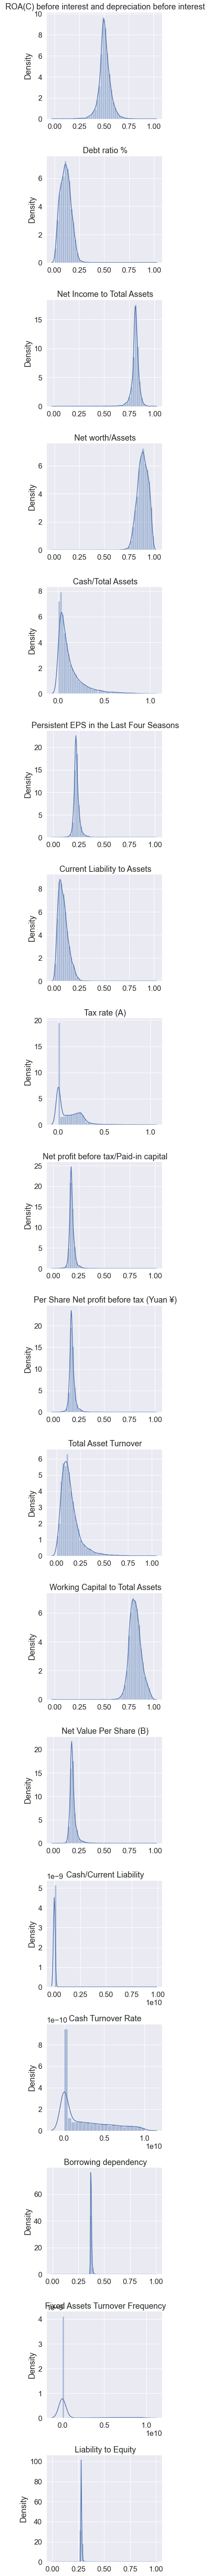

In [155]:

fig, axs = plt.subplots(len(to_plot_vars), 1, figsize=(5, 80))

data = [df[key] for key in to_plot_vars]

for i in range(len(to_plot_vars)):
    sns.distplot(a = [data[i]], ax=axs[i])
    axs[i].set_title(to_plot_vars[i])

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel=' Tax rate (A)', ylabel='Density'>

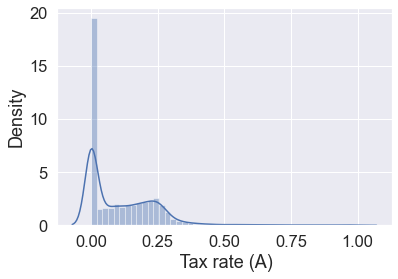

In [156]:
sns.distplot(a = df[" Tax rate (A)"])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel=' Cash Turnover Rate', ylabel='Density'>

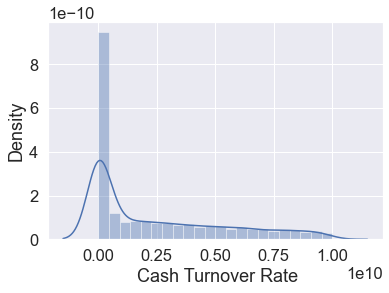

In [157]:
sns.distplot(a = df[" Cash Turnover Rate"])

***DATA PREPROCESSING***

Разделим исходную выборку на трейн и тест

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Bankrupt?', axis = 1), df["Bankrupt?"], test_size=0.3, random_state=42)

In [160]:
X_train.head()

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Realized Sales Gross Margin,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,...,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Equity to Liability
5632,0.500951,0.600614,0.600549,5.560000e+09,1.320000e+09,0.455697,2.210221e-04,0.060634,0.182040,0.221329,...,0.511316,0.035571,0,0.820175,0.002280,0.600611,0.841847,0.278811,0.026855,0.033673
903,0.479647,0.609666,0.609666,2.556723e-04,1.033993e-04,0.461817,3.400340e-04,0.000000,0.183136,0.209795,...,0.567388,0.039943,0,0.789320,0.001707,0.609661,0.839409,0.281799,0.025910,0.023831
2666,0.516502,0.610682,0.610682,1.152896e-04,3.170000e+09,0.488067,1.428743e-02,0.098998,0.181113,0.226624,...,0.649930,0.012145,0,0.826516,0.000909,0.610681,0.841642,0.275619,0.026792,0.113503
109,0.446302,0.595771,0.595771,1.088139e-04,0.000000e+00,0.463550,5.560556e-04,0.000000,0.176942,0.208093,...,0.572769,0.041839,0,0.794111,0.015785,0.595770,0.839915,0.277858,0.026101,0.040701
5316,0.501194,0.600001,0.600001,3.760000e+09,7.980000e+07,0.465538,7.500000e+08,0.247393,0.177194,0.224449,...,0.612266,0.026476,0,0.811586,0.002546,0.600001,0.841244,0.279156,0.026794,0.031863


Посмотрим, в каких диапазонах распределены признаки. Возможно, нам нужно нормализовать фичи.

In [161]:
X_train_distributions = X_train.describe()
X_train_distributions

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Realized Sales Gross Margin,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,...,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Equity to Liability
count,4773.000000,4773.000000,4773.000000,4.773000e+03,4.773000e+03,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,...,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000
mean,0.506072,0.607956,0.607942,2.008203e+09,1.958778e+09,0.467482,1.584412e+07,0.114850,0.191085,0.229262,...,0.594012,0.031410,0.001048,0.808175,1.739661e+07,0.607955,0.840376,0.280297,0.027675,0.048156
std,0.061579,0.016953,0.016937,3.238046e+09,2.602280e+09,0.017944,1.066087e+08,0.137185,0.034431,0.034022,...,0.058923,0.029302,0.032352,0.041235,3.765608e+08,0.016953,0.015853,0.011386,0.018473,0.052477
min,0.000000,0.000000,0.000000,1.000256e-04,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.078567,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.133503,0.000000,0.000000
25%,0.476820,0.600492,0.600499,1.552998e-04,1.269995e-04,0.461606,2.040204e-04,0.000000,0.173823,0.214806,...,0.566617,0.018002,0.000000,0.797064,9.110040e-04,0.600492,0.840138,0.276928,0.026791,0.024575
50%,0.503778,0.606055,0.606055,2.750992e-04,5.090000e+08,0.465096,3.210321e-04,0.076020,0.184611,0.224827,...,0.593833,0.027717,0.000000,0.810959,2.100891e-03,0.606052,0.841202,0.278752,0.026809,0.033942
75%,0.536684,0.613867,0.613824,4.220000e+09,3.500000e+09,0.471053,5.340534e-04,0.205284,0.199781,0.239293,...,0.624854,0.038432,0.000000,0.827049,5.242171e-03,0.613863,0.842371,0.281417,0.026914,0.053210
max,1.000000,1.000000,1.000000,9.990000e+09,9.980000e+09,1.000000,9.900000e+08,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.982879,9.820000e+09,1.000000,1.000000,0.745352,1.000000,1.000000


In [162]:
X_train_distributions[X_train_distributions>1].count().sort_values(ascending= False) > 1

 Total Asset Growth Rate                                     True
 Cash Turnover Rate                                          True
 Research and development expense rate                       True
 Operating Expense Rate                                      True
 Quick Asset Turnover Rate                                   True
                                                            ...  
 Quick Assets/Total Assets                                  False
 Working Capital to Total Assets                            False
 Operating profit per person                                False
 Degree of Financial Leverage (DFL)                         False
 ROA(C) before interest and depreciation before interest    False
Length: 66, dtype: bool

Как мы можем видеть из таблицы сверху, некоторые данные принадлежат промежутку [0,1], в то время как другие сильно больше единицы. Давайте нормализуем данные, чтобы в дальнейшем мы могли правильно интерпретировать коэффициенты.

In [163]:
from sklearn.preprocessing import MinMaxScaler

In [164]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [165]:
X_train

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Realized Sales Gross Margin,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,...,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Equity to Liability
0,0.500951,0.600614,0.600549,5.565566e-01,1.322645e-01,0.455697,2.232546e-13,0.060634,0.182040,0.154935,...,0.511316,0.035571,0.0,0.834461,2.321818e-13,0.600611,0.841847,0.237490,0.026855,0.033673
1,0.479647,0.609666,0.609666,1.558025e-14,1.036065e-14,0.461817,3.434687e-13,0.000000,0.183136,0.142417,...,0.567388,0.039943,0.0,0.803069,1.738163e-13,0.609661,0.839409,0.242374,0.025910,0.023831
2,0.516502,0.610682,0.610682,1.527930e-15,3.176353e-01,0.488067,1.443175e-11,0.098998,0.181113,0.160681,...,0.649930,0.012145,0.0,0.840913,9.259198e-14,0.610681,0.841642,0.232273,0.026792,0.113503
3,0.446302,0.595771,0.595771,8.797171e-16,0.000000e+00,0.463550,5.616723e-13,0.000000,0.176942,0.140570,...,0.572769,0.041839,0.0,0.807943,1.607411e-12,0.595770,0.839915,0.235933,0.026101,0.040701
4,0.501194,0.600001,0.600001,3.763764e-01,7.995992e-03,0.465538,7.575758e-01,0.247393,0.177194,0.158321,...,0.612266,0.026476,0.0,0.825723,2.592377e-13,0.600001,0.841244,0.238055,0.026794,0.031863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768,0.542729,0.598236,0.598229,2.892893e-01,7.314629e-02,0.473994,2.121424e-13,0.216722,0.279339,0.206033,...,0.629293,0.011114,0.0,0.851075,1.644142e-12,0.598231,0.842331,0.233233,0.026800,0.073707
4769,0.550870,0.610422,0.610228,3.414691e-15,7.945892e-01,0.470431,3.252851e-13,0.012147,0.228098,0.198646,...,0.630594,0.017013,0.0,0.858376,1.093604e-13,0.610419,0.843046,0.234762,0.026820,0.049579
4770,0.507288,0.605529,0.605371,2.453948e-15,1.058181e-14,0.465726,4.000400e-13,0.058305,0.169736,0.157808,...,0.615671,0.026550,0.0,0.827259,1.215807e-13,0.605529,0.841427,0.238969,0.026945,0.029459
4771,0.581339,0.617247,0.617247,1.194563e-14,1.439263e-14,0.470112,2.959892e-13,0.095253,0.216763,0.201621,...,0.622690,0.018808,0.0,0.870617,8.204814e-14,0.617243,0.843619,0.234033,0.026800,0.058283


Проверим, что все фичи нормализованы верно

In [166]:
X_train_distributions = X_train.describe()
X_train_distributions

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Realized Sales Gross Margin,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,...,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Equity to Liability
count,4773.000000,4773.000000,4773.000000,4.773000e+03,4.773000e+03,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,...,4773.000000,4773.000000,4773.000000,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000
mean,0.506072,0.607956,0.607942,2.010214e-01,1.962704e-01,0.467482,1.600416e-02,0.114850,0.191085,0.163545,...,0.594012,0.031410,0.001048,0.822253,1.771548e-03,0.607955,0.840376,0.239919,0.027675,0.048156
std,0.061579,0.016953,0.016937,3.241287e-01,2.607495e-01,0.017944,1.076856e-01,0.137185,0.034431,0.036923,...,0.058923,0.029302,0.032352,0.041953,3.834631e-02,0.016953,0.015853,0.018610,0.018473,0.052477
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476820,0.600492,0.600499,5.532957e-15,1.272540e-14,0.461606,2.060812e-13,0.000000,0.173823,0.147856,...,0.566617,0.018002,0.000000,0.810948,9.277027e-14,0.600492,0.840138,0.234413,0.026791,0.024575
50%,0.503778,0.606055,0.606055,1.752489e-14,5.100200e-02,0.465096,3.242749e-13,0.076020,0.184611,0.158732,...,0.593833,0.027717,0.000000,0.825085,2.139400e-13,0.606052,0.841202,0.237394,0.026809,0.033942
75%,0.536684,0.613867,0.613824,4.224224e-01,3.507014e-01,0.471053,5.394479e-13,0.205284,0.199781,0.174431,...,0.624854,0.038432,0.000000,0.841455,5.338260e-13,0.613863,0.842371,0.241749,0.026914,0.053210
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [167]:
X_train_distributions[X_train_distributions>1].count().sort_values(ascending= False) > 1

 Equity to Liability                                        False
 Cash Reinvestment %                                        False
 Fixed Assets Turnover Frequency                            False
 Inventory Turnover Rate (times)                            False
 Average Collection Days                                    False
                                                            ...  
 Cash/Total Assets                                          False
 Current Assets/Total Assets                                False
 Quick Assets/Total Assets                                  False
 Working Capital to Total Assets                            False
 ROA(C) before interest and depreciation before interest    False
Length: 66, dtype: bool

Теперь так же нормализуем фичи и на X_test

In [168]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [169]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [170]:
print(X_train.columns)

Index([' ROA(C) before interest and depreciation before interest',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Expense Rate', ' Research and development expense rate',
       ' Cash flow rate', ' Interest-bearing debt interest rate',
       ' Tax rate (A)', ' Net Value Per Share (B)',
       ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share',
       ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Cash Reinvestment %', ' Current Ratio',
       ' Quick Ratio', ' Total debt/Total net worth', ' Debt ratio %',
       ' Net worth/Assets', ' Long-term fund suitability ratio (A)',
       ' Borrowing dependency', ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital', ' Total Asset Turnover',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inven

In [171]:
from sklearn.decomposition import PCA

pca = PCA(n_components=46)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [172]:
# from sklearn.decomposition import PCA

# for n_components in range(10, 51):
#     pca = PCA(n_components=n_components)
#     X_transformed = pca.fit_transform(X_train)

***LOGISTIC REGRESSION***

Используем линейную классификацию для того, чтобы оценить важность коэффициентов в регрессии.

In [173]:
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score


In [174]:
best_params = {'C': 0.001597189579515034, 'penalty': 'none', 'solver': 'sag'}

In [175]:
logreg = LogisticRegression(
    C=best_params["C"], 
    penalty=best_params["penalty"], 
    solver=best_params["solver"], 
    random_state=42
)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


F1 Score on test data: 0.6315696173262939
Recall score : 0.8205128205128205


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [176]:
# coef_dict = {}
# for coef, feat in zip(logreg.coef_[0,:],X_train.columns):
#     coef_dict[feat] = coef

# sorted_data = sorted(coef_dict.items(), key = lambda x: -abs(x[1]))

# # Выводим отсортированный список кортежей
# for key, value in sorted_data[:20]:
#     print(key, value)

In [177]:
conf_matrix = confusion_matrix(y_test, y_pred)

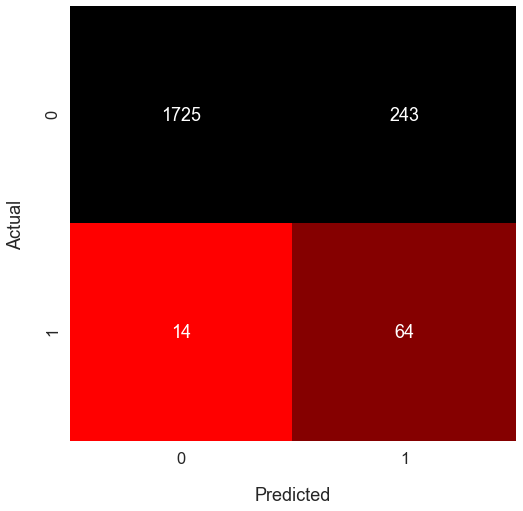

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

Найдем полноту

In [179]:
recall_score(y_true=y_test,y_pred=y_pred)

0.8205128205128205

In [180]:
f1_score(y_true=y_test,y_pred=y_pred)

0.33246753246753247

***SUPPORT VECTORS CLASSIFIER***

Теперь обучим модель с помощью метода опорных векторов.

In [181]:
svc = SVC(kernel="linear")

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


In [182]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [183]:
print(conf_matrix)

[[1692  276]
 [  13   65]]


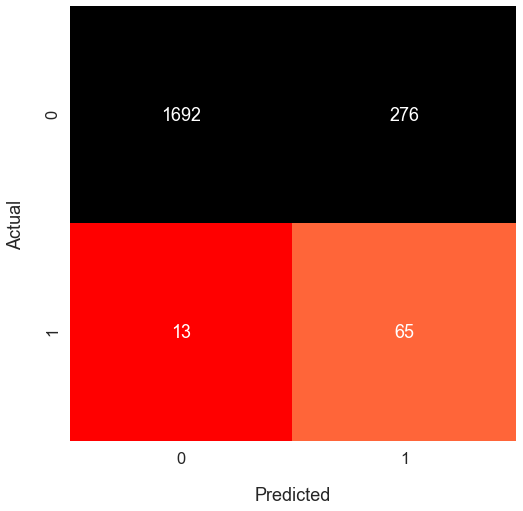

In [184]:
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [185]:
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

F1 Score on test data: 0.6157901268821635
Recall score : 0.8333333333333334


Как мы можем видеть, качество модели упало

In [186]:
# coef_dict = {}
# for coef, feat in zip(svc.coef_[0,:],X_train.columns):
#     coef_dict[feat] = coef

# sorted_data = sorted(coef_dict.items(), key = lambda x: -abs(x[1]))

# # Выводим отсортированный список кортежей
# for key, value in sorted_data[:20]:
#     print(key, value)

***Добавим SMOTE к Logistic Regression***

In [187]:
from imblearn.over_sampling import SMOTE

In [188]:

sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)

In [189]:
logreg = LogisticRegression(solver='liblinear')


logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

In [190]:
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

F1 Score on test data: 0.6253939149330846
Recall score : 0.8461538461538461


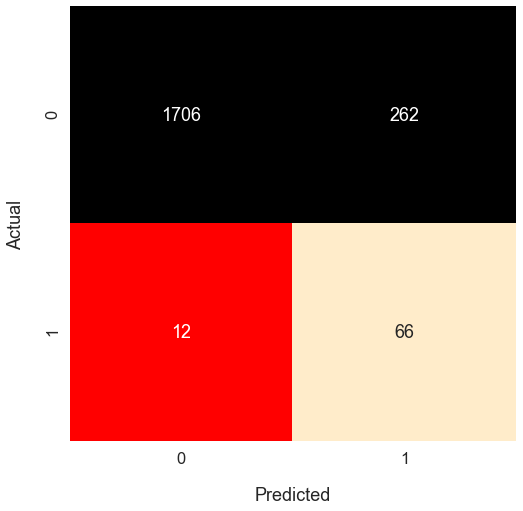

In [191]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

***Добавим ADASYN***

In [192]:
from imblearn.over_sampling import ADASYN

In [193]:
ada = ADASYN(random_state=42)

X_train, y_train = ada.fit_resample(X_train, y_train)

In [194]:
logreg = LogisticRegression(solver='liblinear')


logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

In [195]:
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

F1 Score on test data: 0.6253939149330846
Recall score : 0.8461538461538461


***Перебор гиперпараметров логистической регрессии с помощью OPTUNA***

In [196]:
import optuna
from sklearn.model_selection import cross_val_score

# определяем функцию, которую мы хотим оптимизировать
def objective(trial):
    # предлагаем значения для гиперпараметров
    C = trial.suggest_loguniform('C', 1e-5, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])

    # обучаем и проверяем модель на основе предложенных гиперпараметров
    lr = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42)
    score = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1_macro').mean()

    return score

# создаем объект study и оптимизируем функцию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# получаем лучшие гиперпараметры
best_params = study.best_params


[I 2023-06-13 06:11:03,604] A new study created in memory with name: no-name-bfd23414-26b0-412c-9035-b9834ed120e0
<ipython-input-196-edcb754d0ad9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 100)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaco

In [197]:
best_params

{'C': 1.1538993139136786, 'penalty': 'none', 'solver': 'newton-cg'}

In [198]:
best_params = study.best_params

lr = LogisticRegression(
    C=best_params["C"], 
    penalty=best_params["penalty"], 
    solver=best_params["solver"], 
    random_state=42
)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


F1 Score on test data: 0.6362903225806451
Recall score : 0.8076923076923077


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [199]:
# comp_dict = {}

# from sklearn.decomposition import PCA

# for n_components in range(10, 51):
#     df = pd.read_csv("data.csv")
#     df = df[df.columns.drop(vars_high_correlation, vars_low_variance)]

#     X_train, X_test, y_train, y_test = train_test_split(df.drop('Bankrupt?', axis = 1), df["Bankrupt?"], test_size=0.3, random_state=42)

#     X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#     X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
#     pca = PCA(n_components=n_components)
#     X_train = pca.fit_transform(X_train)
#     X_test = pca.transform(X_test)

#     lr = LogisticRegression(
#     C=best_params["C"], 
#     penalty=best_params["penalty"], 
#     solver=best_params["solver"], 
#     random_state=42
#     )

#     lr.fit(X_train, y_train)

#     y_pred = lr.predict(X_test)

#     f1 = f1_score(y_test, y_pred)

#     comp_dict[n_components]=f1

In [200]:
# sorted_ncomponents= sorted(comp_dict.items(), key = lambda x: -abs(x[1]))

# # Выводим отсортированный список кортежей
# for key, value in sorted_ncomponents[:5]:
#     print(key, value)

***Решающее дерево***

In [201]:
from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)


f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

F1 Score on test data: 0.6042970673043111
Recall score : 0.38461538461538464


***Random Forest***

In [202]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)

F1 Score on test data: 0.6885010532077065
Recall score : 0.3333333333333333


***XGBOOST***

In [203]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Определяем сетку гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим наилучшие параметры
print("Best Parameters: ", grid_search.best_params_)

# Сделаем прогнозы с использованием лучшей модели
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)


print("F1 Score on test data:", f1)
print("Recall score :", recall)


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.p

Best Parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
F1 Score on test data: 0.6885010532077065
Recall score : 0.3333333333333333


***CatBoost***

In [206]:
pip install --upgrade pip setuptools wheel

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
  Attempting uninstall: setuptools
    Found existing installation: setuptools 50.3.1.post20201107
    Uninstalling setuptools-50.3.1.post20201107:
      Successfully uninstalled setuptools-50.3.1.post20201107
  Attempting uninstall: wheel
    Found existing installation: wheel 0.35.1
    Uninstalling wheel-0.35.1:
      Successfully uninstalled wheel-0.35.1
Note: you may need to restart the kernel to use updated packages.


In [207]:
pip install catboost

  Using cached catboost-1.2.tar.gz (95.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for catboost (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-38
      creating build/lib.macosx-10.9-x86_64-cpython-38/catboost
      copying catboost/monoforest.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
      copying catboost/plot_helpers.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
      copying catboost/metrics.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
      copying catboost/version.py -> build/lib.macosx-10.9-x86_64-cpython-38/catboost
      copying catboost/text_processing.py -

In [208]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(loss_function='MultiClass', verbose=False)

# Определяем сетку гиперпараметров
param_grid = {
    'iterations': [50, 100, 150],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим наилучшие параметры
print("Best Parameters: ", grid_search.best_params_)

# Сделаем прогнозы с использованием лучшей модели
best_model = grid_search.best_estimator_
preds_class = best_model.predict(X_test)

# Оценим модель
print("F1-score = {}".format(f1_score(y_test, preds_class)))


ModuleNotFoundError: No module named 'catboost'